In [1]:
from __future__ import print_function
import pylab

import numpy as np

import matplotlib.pyplot as plt
import time
import os
import pickle
import random

import pandas as pd

import random

#from category_encoders import *

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

plt.style.use('seaborn-white')

pylab.ion()

In [2]:
import scipy.integrate as integrate
from numpy import sqrt, sin, cos, pi, tan, sinh, cosh, exp, tanh, log, log10
import scipy.special as ssf
import math

In [3]:
from multiprocessing import Pool
from multiprocessing import cpu_count
import emcee
from tqdm import tqdm

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

16 CPUs


In [4]:
def make_lower(side_len):
    mask = np.zeros((side_len, side_len), dtype = np.intc)
    for i in range(side_len):
        for j in range(i+1):
            mask[i, j] = 1
    mask = torch.from_numpy(mask)
    return mask

def make_diag(side_len):
    mask = np.zeros((side_len, side_len), dtype = np.intc)
    for i in range(side_len):
        mask[i, i] = 1
    mask = torch.from_numpy(mask)
    return mask

In [5]:
def psiHOpoint(n, x):
    return exp(-0.5*x*x)*ssf.hermite(n)(x)/sqrt(math.factorial(n)*sqrt(pi)*2**n)

def psiHO(n, x):
    x=np.array(x)
    return exp(-0.5*x*x)*ssf.hermite(n)(x)/sqrt(math.factorial(n)*sqrt(pi)*2**n)

def psiHOall(n, x):
    return np.array([psiHO(i, x) for i in range(n+1)])

def HM(n, x):
    return np.array([psiHO(i, x) for i in range(n+1)]).T

def FM(k, L, x): #k Fourier modes in the interval (-L,L)
    x=np.array(x)
    xkmat = np.reshape(x, [len(x),1])*np.array(range(1,k+1))
    zeromode = 1/sqrt(2*L)*np.ones([len(x),1])
    cosmodes = cos(xkmat*pi/L)/sqrt(L)
    sinmodes = sin(xkmat*pi/L)/sqrt(L)
    return np.concatenate((zeromode,cosmodes,sinmodes),axis=1)

def FCpsiHO(n, k, L) :#k Fourier coefficients for the nth harmonic oscillator wavefunction in (-L,L)
    coeff0 = np.array([integrate.quad(lambda x: psiHOpoint(n, x)/sqrt(2*L), -L, L)[0]])
    coeffcos = np.array([integrate.quad(lambda x: psiHOpoint(n, x)*cos(x*i*pi/L)/sqrt(L), -L, L)[0] \
                         for i in range(1,k+1)])
    coeffsin = np.array([integrate.quad(lambda x: psiHOpoint(n, x)*sin(x*i*pi/L)/sqrt(L), -L, L)[0] \
                         for i in range(1,k+1)])
    return np.concatenate((coeff0,coeffcos,coeffsin))

In [6]:
def FM0(k, L, x): #k Fourier modes in the interval (-L,L)
    kvec = np.array(range(1,k+1))
    zeromode = 1/sqrt(2*L)
    cosmodes = cos(kvec*x*pi/L)/sqrt(L)
    sinmodes = sin(kvec*x*pi/L)/sqrt(L)
    return np.concatenate(([zeromode],cosmodes,sinmodes))

def D2FM0(k, L, x): #second derivative of k Fourier modes in the interval (-L,L)
    kvec = np.array(range(1,k+1))
    zeromode = 0
    cosmodes = -(kvec*pi/L)**2*cos(kvec*x*pi/L)/sqrt(L)
    sinmodes = -(kvec*pi/L)**2*sin(kvec*x*pi/L)/sqrt(L)
    return np.concatenate(([zeromode],cosmodes,sinmodes))

def H_HO_FM_int(k, L):
    return np.array([[integrate.quad(lambda x: FM0(k, L, x)[i]*(x**2*FM0(k, L, x)[j]- D2FM0(k, L, x)[j]), -L, L)[0] \
                     for i in range(2*k+1)] for j in range(2*k+1)])

def V_AHO(x):
    return -x**2/2-x+x**4/16

def H_AHO_FM_int(k, L, V): #V is the function that calculates the potential
    return np.array([[integrate.quad(lambda x: FM0(k, L, x)[i]*(2*V(x)*FM0(k, L, x)[j]- D2FM0(k, L, x)[j]), -L, L)[0] \
                     for i in range(2*k+1)] for j in range(2*k+1)])

In [7]:
def tridiag(a, b, c, k1=-1, k2=0, k3=1):
    return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)

def K(n):
    upper = -1*np.ones(n-1)
    center = np.concatenate(([1],2*np.ones(n-2),[1]))
    return tridiag(upper,center,upper)

def covHO(n,a):
    upper = -1*np.ones(n-1)
    center = np.concatenate(([1+a**2],(2+a**2)*np.ones(n-2),[1+a**2]))
    return np.linalg.inv(1/a*tridiag(upper,center,upper))

def solveHOE(t,a,b,T):
    t=np.array(t)
    return a*cosh(t) + (-a*cosh(T)/sinh(T) + b/sinh(T))*sinh(t)

In [8]:
def V_AHO(x):
    return -x**2/2-x+x**4/16

def lnprob_V(x, n, a):
    return -np.dot(x,np.dot(K(n),x))/2.0/a - np.sum(a*V_AHO(x))

In [9]:
T = 2

In [10]:
class HM_PT(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, n=10):
        ctx.save_for_backward(x)
        x_np = x.numpy()
        z = HM(n,x_np)
        
        return torch.from_numpy(z)

    @staticmethod
    def backward(ctx, grad_output_torch):
        [x_torch] = ctx.saved_tensors

        x = x_torch.numpy()
        [x_len, n] = list(grad_output_torch.size())
        
        
        psiHO_der = np.array([exp(-0.5*x*x)*(x*ssf.hermite(i)(x) - ssf.hermite(i+1)(x))/sqrt(math.factorial(i)*sqrt(pi)*2**i) \
                                                                                        for i in range(n)])
        psiHO_der = torch.from_numpy(psiHO_der)
        grad_input = [torch.matmul(grad_output_torch[i,:], psiHO_der[:,i]) for i in range(x_len)]
        

        return torch.Tensor(grad_input), None
    
def flow(coeff, x, latt_pt):
    coeff = coeff.reshape([-1,1])
    x = x.reshape([-1,1]) 
    latt_pt = latt_pt.reshape([1, -1])
    a = x - latt_pt
    z = torch.tanh(a)
    z = torch.matmul(z, coeff)
    z = z.reshape(-1,)
    
    det_x = torch.matmul(1/(torch.cosh(a)**2), coeff)
    
    return z, det_x

In [11]:
class QML(nn.Module):
    def __init__(self, n_ES, n_B):
        super(QML, self).__init__()
        
        self.n_Ba = n_B
        self.n_EL = n_ES + 1
        
        n_latt_spacing = 400
        self.fl_prm = torch.nn.Parameter(torch.from_numpy(np.ones((n_latt_spacing+1,), dtype = float)))
        self.fl_prm.requires_grad = True
        self.latt_pt = torch.from_numpy(np.linspace(-10, 10, num = n_latt_spacing+1))
        self.latt_pt.requires_grad = False
        
        self.levels = torch.nn.Parameter(torch.from_numpy(np.random.uniform(1,2,self.n_EL)))
        self.levels.requires_grad = True
        
        self.var_BaC = torch.nn.Parameter(torch.from_numpy(np.random.uniform(-1,1,[self.n_Ba, self.n_EL])))
        self.var_BaC.requires_grad = True
        
        self.mask = (make_lower(self.n_EL) - make_diag(self.n_EL) ) > 0 #convert to boolean
        self.diag = make_diag(self.n_EL) > 0 #convert to boolean  
   
        
    def forward(self, x, y):
        
        fl_var = self.fl_prm * self.fl_prm
        [fl_x, det_fl_x] = flow(fl_var, x, self.latt_pt)
        [fl_y, det_fl_y] = flow(fl_var, y, self.latt_pt)
        hm = HM_PT.apply
        psi_x = hm(fl_x, self.n_Ba-1)
        psi_y = hm(fl_y, self.n_Ba-1)
        
        psi_x = torch.sqrt(det_fl_x) * psi_x
        psi_y = torch.sqrt(det_fl_y) * psi_y
        
        norms_BaC = torch.linalg.norm(self.var_BaC, dim = 0)
        var_BaC_N = self.var_BaC/norms_BaC
        logits = F.softmin(self.levels, dim = 0)
        
        c_orth = 1000
        loss_orth = c_orth * torch.mean(torch.masked_select(torch.matmul(torch.transpose(var_BaC_N, 0, 1),var_BaC_N) \
                                                                  , self.mask)**2)
        
        loss_ML = -1 * torch.mean(torch.matmul( torch.matmul(psi_x, var_BaC_N) * torch.matmul(psi_y, var_BaC_N) \
                    , torch.log(logits*(10**4.)+1) ) )
        
        loss = loss_orth + loss_ML
        
        return loss, loss_ML, loss_orth, self.levels, logits 

In [12]:
def main_train_states_QML(G, in_x, in_y, batch_size = 500, epochs = 200000, step = 1e-3):
    n_samples = len(in_x)
        
        
    optimiser = torch.optim.Adam(G.parameters(), lr=step)
    
    
    loss_hist = np.zeros((epochs,), dtype = float)
    loss_ML_hist = np.zeros((epochs,), dtype = float)
    loss_orth_hist = np.zeros((epochs,), dtype = float)
    
    levels_hist = np.zeros((epochs, G.n_EL), dtype = float)
    logits_hist = np.zeros((epochs, G.n_EL), dtype = float)
        
        
    start_time = time.time()
    for i in range(epochs):
        
        idx = np.random.choice(n_samples, batch_size, replace=True)
        #mini_in_x = in_x[idx]
        #mini_in_y = in_y[idx]
        
        #loop_start = time.time()
        
        [loss, loss_ML, loss_orth, levels, logits] = G(in_x[idx], in_y[idx])
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
        
        loss_hist[i] = loss.tolist()
        loss_ML_hist[i] = loss_ML.tolist()
        loss_orth_hist[i] = loss_orth.tolist()
        
        levels_hist[i, :] = levels.tolist()
        logits_hist[i, :] = logits.tolist()
            
        #loop_end = time.time()
        #print('Time taken for loop ' + str(i) + ': {0:.3f} seconds'.format(loop_end - loop_start))
        
        if i % 1000 == 0:
                
            print('Batch number ', i)
            print('Loss: ', loss_hist[i])
            print('Loss_orth: ', loss_orth_hist[i])
            print('Loss_ML: ', loss_ML_hist[i])
            print('Logits: ', logits)
            end_time = time.time()
            print('Time taken: {0:.3f} seconds'.format(end_time - start_time))
            start_time = time.time()
            print('@----------------------------------------------------------@')
            #writer.add_summary(summary, i)
            #writer.flush()
                
        
          
                
    var_BaC = G.var_BaC
    norms_BaC = torch.linalg.norm(var_BaC, dim = 0)
    var_BaC_N = (var_BaC / norms_BaC).detach().numpy() #normalise the coefficients of basis states
    levels_hist = np.array(levels_hist)
    logits_hist = np.array(logits_hist)
    
    
    ##Sort energy levels and associated coefficients of basis states in ascending order
    fin_EL = G.levels
    fin_EL = fin_EL.detach()
    fin_logits = F.softmin(fin_EL, dim = 0)
    fin_EL = fin_EL.numpy()
    fin_logits = fin_logits.numpy()
    fl_coeff = (G.fl_prm * G.fl_prm).detach().numpy()
    
    fin_EL_argsort = fin_EL.argsort()
    levels_hist = levels_hist[:, fin_EL_argsort]
    logits_hist = logits_hist[:, fin_EL_argsort]
    var_BaC_N = var_BaC_N[:, fin_EL_argsort]
    fin_EL = fin_EL[fin_EL_argsort]
    fin_logits = fin_logits[fin_EL_argsort]
    #EL_ranks = np.empty_like(fin_EL_argsort)
    #EL_ranks[fin_EL_argsort] = np.arange(len(fin_EL))
    
    return loss_hist, loss_ML_hist, loss_orth_hist, levels_hist, logits_hist, var_BaC_N, fl_coeff, fin_EL, fin_logits

In [13]:
infile = "AHO_PI_MCMC_T" + str(T) + ".npy"
paths = np.load(infile)
print(paths.shape)

x = torch.from_numpy(paths[:, 0])
y = torch.from_numpy(paths[:, -1])

del paths

(100000000, 40)


In [14]:
n_samples = 100000000
batch_size = 500
start_time = time.time()
idx = np.random.choice(n_samples, batch_size, replace=True)
end_time = time.time()
print(end_time-start_time)

0.00257110595703125


In [15]:
n_EL = 10
n_Hm = 10

epochs = 800000
qml_AHO_HM = QML(n_EL, n_Hm+1)

[loss_hist, loss_ML_hist, loss_orth_hist, levels_hist, logits_hist, var_HC_N, fl_coeff, levels_fin, logits_fin] = \
            main_train_states_QML(qml_AHO_HM, x, y, 500, epochs)

/home/scl489/.env/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


Batch number  0
Loss:  83.6453107483901
Loss_orth:  83.64613219058762
Loss_ML:  -0.0008214421975240239
Logits:  tensor([0.0807, 0.1002, 0.0712, 0.1061, 0.0888, 0.1436, 0.1006, 0.0857, 0.0649,
        0.0850, 0.0732], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 0.350 seconds
@----------------------------------------------------------@
Batch number  1000
Loss:  -0.26303308823356614
Loss_orth:  0.0003943133753145555
Loss_ML:  -0.2634274016088807
Logits:  tensor([0.0870, 0.1163, 0.0654, 0.1161, 0.0846, 0.1284, 0.1092, 0.0739, 0.0652,
        0.0853, 0.0686], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 48.675 seconds
@----------------------------------------------------------@
Batch number  2000
Loss:  -0.028258788574325
Loss_orth:  0.0002750553722276197
Loss_ML:  -0.02853384394655262
Logits:  tensor([0.0987, 0.1401, 0.0590, 0.1269, 0.0848, 0.1063, 0.1057, 0.0671, 0.0658,
        0.0806, 0.0650], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 46.

Batch number  23000
Loss:  0.08799339788654442
Loss_orth:  0.004200810573865216
Loss_ML:  0.0837925873126792
Logits:  tensor([0.0679, 0.7411, 0.0099, 0.0756, 0.0168, 0.0110, 0.0279, 0.0094, 0.0144,
        0.0145, 0.0115], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 47.808 seconds
@----------------------------------------------------------@
Batch number  24000
Loss:  0.0014881894411140181
Loss_orth:  0.004466806577376802
Loss_ML:  -0.002978617136262784
Logits:  tensor([0.0550, 0.7945, 0.0082, 0.0572, 0.0136, 0.0087, 0.0219, 0.0080, 0.0119,
        0.0119, 0.0091], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 48.678 seconds
@----------------------------------------------------------@
Batch number  25000
Loss:  -0.09007151787750363
Loss_orth:  0.0023928656350720836
Loss_ML:  -0.09246438351257572
Logits:  tensor([0.0411, 0.8350, 0.0068, 0.0460, 0.0116, 0.0076, 0.0170, 0.0066, 0.0104,
        0.0098, 0.0080], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Ti

Batch number  46000
Loss:  -3.944656119840701
Loss_orth:  0.0063262607086007555
Loss_ML:  -3.9509823805493016
Logits:  tensor([0.0590, 0.5004, 0.0036, 0.0030, 0.2426, 0.0112, 0.0334, 0.1308, 0.0039,
        0.0061, 0.0059], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 45.254 seconds
@----------------------------------------------------------@
Batch number  47000
Loss:  -3.88085683481671
Loss_orth:  0.0023859320540274578
Loss_ML:  -3.8832427668707377
Logits:  tensor([0.0638, 0.4974, 0.0033, 0.0029, 0.2408, 0.0098, 0.0360, 0.1290, 0.0041,
        0.0064, 0.0064], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 50.633 seconds
@----------------------------------------------------------@
Batch number  48000
Loss:  -4.1589594175119196
Loss_orth:  0.003941597032023253
Loss_ML:  -4.162901014543943
Logits:  tensor([0.0658, 0.4964, 0.0030, 0.0028, 0.2398, 0.0081, 0.0371, 0.1298, 0.0041,
        0.0062, 0.0068], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken

Batch number  69000
Loss:  -4.212835650866328
Loss_orth:  0.005239278228958173
Loss_ML:  -4.218074929095287
Logits:  tensor([0.0818, 0.4566, 0.0013, 0.0083, 0.2250, 0.0066, 0.0524, 0.1210, 0.0011,
        0.0150, 0.0309], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.366 seconds
@----------------------------------------------------------@
Batch number  70000
Loss:  -4.503793187081524
Loss_orth:  0.007468178778799838
Loss_ML:  -4.5112613658603244
Logits:  tensor([0.0815, 0.4564, 0.0013, 0.0083, 0.2242, 0.0062, 0.0530, 0.1212, 0.0011,
        0.0156, 0.0311], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.488 seconds
@----------------------------------------------------------@
Batch number  71000
Loss:  -4.423018563113226
Loss_orth:  0.004210012577103486
Loss_ML:  -4.42722857569033
Logits:  tensor([0.0836, 0.4560, 0.0013, 0.0085, 0.2240, 0.0061, 0.0527, 0.1194, 0.0011,
        0.0160, 0.0313], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43

Batch number  92000
Loss:  -4.563282155728005
Loss_orth:  0.0007199002903475791
Loss_ML:  -4.564002056018352
Logits:  tensor([0.0811, 0.4602, 0.0008, 0.0096, 0.2169, 0.0055, 0.0538, 0.1176, 0.0006,
        0.0199, 0.0339], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 48.472 seconds
@----------------------------------------------------------@
Batch number  93000
Loss:  -4.347768279600482
Loss_orth:  0.004250618543858241
Loss_ML:  -4.35201889814434
Logits:  tensor([0.0813, 0.4593, 0.0008, 0.0095, 0.2183, 0.0055, 0.0536, 0.1181, 0.0006,
        0.0196, 0.0333], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 48.831 seconds
@----------------------------------------------------------@
Batch number  94000
Loss:  -4.499730150146396
Loss_orth:  0.0037965948039025152
Loss_ML:  -4.503526744950299
Logits:  tensor([0.0822, 0.4573, 0.0008, 0.0098, 0.2189, 0.0057, 0.0535, 0.1174, 0.0006,
        0.0198, 0.0340], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 4

Batch number  115000
Loss:  -4.359506525255885
Loss_orth:  0.0007742730072452487
Loss_ML:  -4.36028079826313
Logits:  tensor([0.0808, 0.4625, 0.0006, 0.0106, 0.2134, 0.0059, 0.0547, 0.1172, 0.0007,
        0.0196, 0.0341], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 42.955 seconds
@----------------------------------------------------------@
Batch number  116000
Loss:  -4.336105812637429
Loss_orth:  0.0004841194216774857
Loss_ML:  -4.336589932059106
Logits:  tensor([0.0804, 0.4646, 0.0006, 0.0106, 0.2148, 0.0059, 0.0543, 0.1152, 0.0007,
        0.0195, 0.0333], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 42.805 seconds
@----------------------------------------------------------@
Batch number  117000
Loss:  -4.843397290706315
Loss_orth:  0.0007928685182692548
Loss_ML:  -4.844190159224585
Logits:  tensor([0.0811, 0.4642, 0.0006, 0.0105, 0.2134, 0.0058, 0.0538, 0.1177, 0.0007,
        0.0193, 0.0330], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time take

Batch number  138000
Loss:  -4.4798551137584965
Loss_orth:  0.0004631912483529899
Loss_ML:  -4.48031830500685
Logits:  tensor([0.0805, 0.4607, 0.0006, 0.0104, 0.2158, 0.0064, 0.0536, 0.1174, 0.0011,
        0.0197, 0.0337], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 45.708 seconds
@----------------------------------------------------------@
Batch number  139000
Loss:  -4.577243484050183
Loss_orth:  0.0011792136797901046
Loss_ML:  -4.578422697729973
Logits:  tensor([0.0806, 0.4617, 0.0006, 0.0104, 0.2152, 0.0063, 0.0535, 0.1173, 0.0011,
        0.0195, 0.0337], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.256 seconds
@----------------------------------------------------------@
Batch number  140000
Loss:  -4.494771333311221
Loss_orth:  0.001060519190611859
Loss_ML:  -4.4958318525018335
Logits:  tensor([0.0803, 0.4651, 0.0006, 0.0111, 0.2125, 0.0062, 0.0531, 0.1160, 0.0011,
        0.0202, 0.0338], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time tak

Batch number  161000
Loss:  -4.5038066193553545
Loss_orth:  0.0007311460185059182
Loss_ML:  -4.50453776537386
Logits:  tensor([0.0800, 0.4654, 0.0007, 0.0102, 0.2144, 0.0063, 0.0535, 0.1168, 0.0011,
        0.0188, 0.0327], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 47.271 seconds
@----------------------------------------------------------@
Batch number  162000
Loss:  -4.675203175205415
Loss_orth:  0.0009285341677007483
Loss_ML:  -4.676131709373116
Logits:  tensor([0.0806, 0.4630, 0.0007, 0.0104, 0.2147, 0.0062, 0.0539, 0.1165, 0.0011,
        0.0195, 0.0333], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 48.316 seconds
@----------------------------------------------------------@
Batch number  163000
Loss:  -4.394852645920293
Loss_orth:  0.0007714818964977301
Loss_ML:  -4.395624127816791
Logits:  tensor([0.0794, 0.4625, 0.0007, 0.0105, 0.2159, 0.0060, 0.0533, 0.1177, 0.0011,
        0.0198, 0.0332], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time tak

Batch number  184000
Loss:  -4.268120598371681
Loss_orth:  0.00025177349547472245
Loss_ML:  -4.268372371867155
Logits:  tensor([0.0800, 0.4632, 0.0006, 0.0108, 0.2135, 0.0063, 0.0530, 0.1183, 0.0014,
        0.0194, 0.0334], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 48.223 seconds
@----------------------------------------------------------@
Batch number  185000
Loss:  -4.201585730311158
Loss_orth:  0.0005574864679385325
Loss_ML:  -4.202143216779096
Logits:  tensor([0.0804, 0.4628, 0.0006, 0.0109, 0.2133, 0.0065, 0.0536, 0.1176, 0.0014,
        0.0198, 0.0332], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 47.836 seconds
@----------------------------------------------------------@
Batch number  186000
Loss:  -4.37929938141787
Loss_orth:  0.00045906657379036375
Loss_ML:  -4.3797584479916605
Logits:  tensor([0.0798, 0.4622, 0.0006, 0.0109, 0.2142, 0.0065, 0.0538, 0.1171, 0.0014,
        0.0198, 0.0335], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time t

Batch number  207000
Loss:  -4.393502196570497
Loss_orth:  0.0005211351970788759
Loss_ML:  -4.394023331767576
Logits:  tensor([0.0793, 0.4608, 0.0007, 0.0111, 0.2150, 0.0064, 0.0534, 0.1182, 0.0016,
        0.0202, 0.0333], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.124 seconds
@----------------------------------------------------------@
Batch number  208000
Loss:  -4.399849671239618
Loss_orth:  0.0005211208065705182
Loss_ML:  -4.400370792046188
Logits:  tensor([0.0792, 0.4626, 0.0006, 0.0107, 0.2150, 0.0063, 0.0535, 0.1169, 0.0016,
        0.0204, 0.0332], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 42.768 seconds
@----------------------------------------------------------@
Batch number  209000
Loss:  -4.271832918169976
Loss_orth:  0.00045802459117164963
Loss_ML:  -4.272290942761148
Logits:  tensor([0.0810, 0.4597, 0.0007, 0.0111, 0.2122, 0.0067, 0.0544, 0.1187, 0.0016,
        0.0202, 0.0338], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time ta

Batch number  230000
Loss:  -4.429987315814102
Loss_orth:  0.00024944066078718194
Loss_ML:  -4.430236756474889
Logits:  tensor([0.0795, 0.4633, 0.0006, 0.0110, 0.2122, 0.0066, 0.0539, 0.1173, 0.0019,
        0.0201, 0.0338], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 46.909 seconds
@----------------------------------------------------------@
Batch number  231000
Loss:  -4.449500684875663
Loss_orth:  0.0002535494441770581
Loss_ML:  -4.44975423431984
Logits:  tensor([0.0796, 0.4624, 0.0006, 0.0107, 0.2139, 0.0067, 0.0543, 0.1174, 0.0019,
        0.0194, 0.0331], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 46.221 seconds
@----------------------------------------------------------@
Batch number  232000
Loss:  -4.317438294146344
Loss_orth:  0.0008089202692814892
Loss_ML:  -4.318247214415625
Logits:  tensor([0.0809, 0.4564, 0.0006, 0.0108, 0.2163, 0.0068, 0.0540, 0.1190, 0.0019,
        0.0201, 0.0333], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time tak

Batch number  253000
Loss:  -4.535791131233819
Loss_orth:  0.00032316290645221986
Loss_ML:  -4.536114294140272
Logits:  tensor([0.0805, 0.4597, 0.0005, 0.0112, 0.2129, 0.0064, 0.0536, 0.1184, 0.0023,
        0.0202, 0.0342], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 46.017 seconds
@----------------------------------------------------------@
Batch number  254000
Loss:  -4.337152909367366
Loss_orth:  0.0004247705404644752
Loss_ML:  -4.33757767990783
Logits:  tensor([0.0801, 0.4645, 0.0006, 0.0108, 0.2132, 0.0062, 0.0531, 0.1165, 0.0023,
        0.0194, 0.0333], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.847 seconds
@----------------------------------------------------------@
Batch number  255000
Loss:  -4.556583430203958
Loss_orth:  0.001994594736884682
Loss_ML:  -4.558578024940842
Logits:  tensor([0.0799, 0.4654, 0.0005, 0.0107, 0.2125, 0.0061, 0.0534, 0.1170, 0.0024,
        0.0193, 0.0328], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time take

Batch number  276000
Loss:  -4.508376428981064
Loss_orth:  0.0005614095959395513
Loss_ML:  -4.508937838577004
Logits:  tensor([0.0805, 0.4593, 0.0006, 0.0111, 0.2146, 0.0062, 0.0536, 0.1186, 0.0022,
        0.0197, 0.0335], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 45.672 seconds
@----------------------------------------------------------@
Batch number  277000
Loss:  -4.449130880707219
Loss_orth:  0.0003915900752792688
Loss_ML:  -4.449522470782498
Logits:  tensor([0.0803, 0.4606, 0.0006, 0.0109, 0.2139, 0.0063, 0.0543, 0.1175, 0.0024,
        0.0195, 0.0336], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 47.216 seconds
@----------------------------------------------------------@
Batch number  278000
Loss:  -4.1293878730333455
Loss_orth:  0.00045441957303903285
Loss_ML:  -4.1298422926063845
Logits:  tensor([0.0814, 0.4598, 0.0006, 0.0111, 0.2131, 0.0062, 0.0537, 0.1182, 0.0024,
        0.0200, 0.0336], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time 

Batch number  299000
Loss:  -4.686132151711758
Loss_orth:  0.0007253909628179163
Loss_ML:  -4.686857542674575
Logits:  tensor([0.0797, 0.4626, 0.0006, 0.0110, 0.2140, 0.0062, 0.0541, 0.1170, 0.0026,
        0.0192, 0.0328], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 46.430 seconds
@----------------------------------------------------------@
Batch number  300000
Loss:  -4.4434822967692975
Loss_orth:  0.0010104582719963927
Loss_ML:  -4.444492755041294
Logits:  tensor([0.0803, 0.4614, 0.0006, 0.0111, 0.2126, 0.0061, 0.0538, 0.1191, 0.0026,
        0.0197, 0.0327], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 45.096 seconds
@----------------------------------------------------------@
Batch number  301000
Loss:  -4.316546224470671
Loss_orth:  0.00042356669351361525
Loss_ML:  -4.316969791164185
Logits:  tensor([0.0798, 0.4631, 0.0007, 0.0112, 0.2130, 0.0063, 0.0529, 0.1174, 0.0027,
        0.0196, 0.0332], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time t

Batch number  322000
Loss:  -4.1310633320167165
Loss_orth:  0.0007241672071597867
Loss_ML:  -4.131787499223877
Logits:  tensor([0.0802, 0.4626, 0.0007, 0.0114, 0.2115, 0.0067, 0.0533, 0.1172, 0.0030,
        0.0199, 0.0334], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 49.410 seconds
@----------------------------------------------------------@
Batch number  323000
Loss:  -4.5993323634310075
Loss_orth:  0.0007686930525484856
Loss_ML:  -4.600101056483556
Logits:  tensor([0.0799, 0.4625, 0.0007, 0.0114, 0.2127, 0.0067, 0.0531, 0.1169, 0.0029,
        0.0197, 0.0335], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.846 seconds
@----------------------------------------------------------@
Batch number  324000
Loss:  -4.446754165514773
Loss_orth:  0.0008070551757542633
Loss_ML:  -4.4475612206905275
Logits:  tensor([0.0792, 0.4632, 0.0007, 0.0111, 0.2140, 0.0064, 0.0529, 0.1170, 0.0030,
        0.0196, 0.0329], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time 

Batch number  345000
Loss:  -4.437166791787808
Loss_orth:  0.0009016992341155958
Loss_ML:  -4.438068491021924
Logits:  tensor([0.0801, 0.4594, 0.0008, 0.0113, 0.2156, 0.0065, 0.0539, 0.1162, 0.0028,
        0.0198, 0.0336], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 45.723 seconds
@----------------------------------------------------------@
Batch number  346000
Loss:  -4.273087415716759
Loss_orth:  0.0003072238779534675
Loss_ML:  -4.273394639594713
Logits:  tensor([0.0811, 0.4596, 0.0009, 0.0113, 0.2134, 0.0068, 0.0532, 0.1182, 0.0028,
        0.0196, 0.0333], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 58.427 seconds
@----------------------------------------------------------@
Batch number  347000
Loss:  -4.344935737950932
Loss_orth:  0.0007401089160480812
Loss_ML:  -4.34567584686698
Logits:  tensor([0.0792, 0.4620, 0.0008, 0.0108, 0.2132, 0.0064, 0.0536, 0.1176, 0.0027,
        0.0197, 0.0339], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time take

Batch number  368000
Loss:  -4.559386270042042
Loss_orth:  0.00045372985997481704
Loss_ML:  -4.5598399999020165
Logits:  tensor([0.0801, 0.4657, 0.0009, 0.0107, 0.2119, 0.0060, 0.0527, 0.1175, 0.0025,
        0.0190, 0.0330], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.549 seconds
@----------------------------------------------------------@
Batch number  369000
Loss:  -4.4705472364786205
Loss_orth:  0.0006339736302735619
Loss_ML:  -4.471181210108894
Logits:  tensor([0.0798, 0.4626, 0.0009, 0.0112, 0.2138, 0.0063, 0.0538, 0.1165, 0.0025,
        0.0195, 0.0331], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.200 seconds
@----------------------------------------------------------@
Batch number  370000
Loss:  -4.2734334644706164
Loss_orth:  0.0008449567189962551
Loss_ML:  -4.274278421189613
Logits:  tensor([0.0797, 0.4605, 0.0009, 0.0112, 0.2144, 0.0061, 0.0533, 0.1182, 0.0026,
        0.0197, 0.0334], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time

Batch number  391000
Loss:  -4.204263576431116
Loss_orth:  0.00024972381861148804
Loss_ML:  -4.204513300249728
Logits:  tensor([0.0792, 0.4628, 0.0010, 0.0112, 0.2136, 0.0061, 0.0536, 0.1164, 0.0029,
        0.0196, 0.0335], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 42.706 seconds
@----------------------------------------------------------@
Batch number  392000
Loss:  -4.283510331665076
Loss_orth:  0.0004021964768409924
Loss_ML:  -4.283912528141918
Logits:  tensor([0.0792, 0.4616, 0.0010, 0.0114, 0.2121, 0.0063, 0.0539, 0.1179, 0.0031,
        0.0198, 0.0337], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.393 seconds
@----------------------------------------------------------@
Batch number  393000
Loss:  -4.85924487572561
Loss_orth:  0.00041559410672409016
Loss_ML:  -4.859660469832334
Logits:  tensor([0.0795, 0.4631, 0.0010, 0.0114, 0.2123, 0.0063, 0.0531, 0.1174, 0.0030,
        0.0195, 0.0334], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time ta

Batch number  414000
Loss:  -4.38350354246271
Loss_orth:  0.0007945989593992988
Loss_ML:  -4.384298141422109
Logits:  tensor([0.0793, 0.4616, 0.0009, 0.0110, 0.2142, 0.0061, 0.0542, 0.1178, 0.0029,
        0.0193, 0.0327], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.876 seconds
@----------------------------------------------------------@
Batch number  415000
Loss:  -4.698058836755515
Loss_orth:  0.0003267061752071122
Loss_ML:  -4.698385542930723
Logits:  tensor([0.0806, 0.4571, 0.0009, 0.0115, 0.2145, 0.0065, 0.0545, 0.1181, 0.0029,
        0.0201, 0.0333], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 45.047 seconds
@----------------------------------------------------------@
Batch number  416000
Loss:  -4.390231810962512
Loss_orth:  0.001243940534046448
Loss_ML:  -4.391475751496559
Logits:  tensor([0.0790, 0.4609, 0.0009, 0.0113, 0.2151, 0.0063, 0.0533, 0.1174, 0.0030,
        0.0197, 0.0331], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken

Batch number  437000
Loss:  -4.243509847887387
Loss_orth:  0.00046857246093560885
Loss_ML:  -4.243978420348323
Logits:  tensor([0.0809, 0.4600, 0.0010, 0.0113, 0.2122, 0.0063, 0.0536, 0.1182, 0.0028,
        0.0201, 0.0335], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 45.231 seconds
@----------------------------------------------------------@
Batch number  438000
Loss:  -4.39080687014595
Loss_orth:  0.0005984971440799536
Loss_ML:  -4.39140536729003
Logits:  tensor([0.0790, 0.4622, 0.0010, 0.0112, 0.2136, 0.0063, 0.0533, 0.1174, 0.0029,
        0.0199, 0.0331], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.017 seconds
@----------------------------------------------------------@
Batch number  439000
Loss:  -4.691300115837223
Loss_orth:  0.0012802779961260077
Loss_ML:  -4.6925803938333495
Logits:  tensor([0.0800, 0.4639, 0.0010, 0.0109, 0.2121, 0.0061, 0.0528, 0.1176, 0.0028,
        0.0194, 0.0333], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time tak

Batch number  460000
Loss:  -4.291159112030049
Loss_orth:  0.001101710113738374
Loss_ML:  -4.2922608221437875
Logits:  tensor([0.0799, 0.4580, 0.0009, 0.0115, 0.2142, 0.0065, 0.0539, 0.1170, 0.0032,
        0.0205, 0.0344], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.321 seconds
@----------------------------------------------------------@
Batch number  461000
Loss:  -4.790001061977609
Loss_orth:  0.0004062572724011386
Loss_ML:  -4.7904073192500105
Logits:  tensor([0.0797, 0.4609, 0.0009, 0.0117, 0.2122, 0.0064, 0.0535, 0.1182, 0.0033,
        0.0200, 0.0333], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 46.408 seconds
@----------------------------------------------------------@
Batch number  462000
Loss:  -4.239341654361618
Loss_orth:  0.0011700629577779506
Loss_ML:  -4.240511717319396
Logits:  tensor([0.0809, 0.4606, 0.0009, 0.0116, 0.2133, 0.0062, 0.0535, 0.1165, 0.0032,
        0.0197, 0.0335], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time ta

Batch number  483000
Loss:  -4.7945815132604555
Loss_orth:  0.0005067870386815109
Loss_ML:  -4.795088300299137
Logits:  tensor([0.0806, 0.4593, 0.0010, 0.0114, 0.2124, 0.0062, 0.0545, 0.1177, 0.0029,
        0.0199, 0.0341], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.933 seconds
@----------------------------------------------------------@
Batch number  484000
Loss:  -4.852914978954708
Loss_orth:  0.0008717706508041864
Loss_ML:  -4.853786749605512
Logits:  tensor([0.0810, 0.4609, 0.0010, 0.0112, 0.2133, 0.0061, 0.0533, 0.1173, 0.0029,
        0.0197, 0.0334], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 45.577 seconds
@----------------------------------------------------------@
Batch number  485000
Loss:  -4.488312196706673
Loss_orth:  0.0004762712086357038
Loss_ML:  -4.488788467915309
Logits:  tensor([0.0787, 0.4620, 0.0010, 0.0116, 0.2153, 0.0063, 0.0527, 0.1164, 0.0028,
        0.0198, 0.0333], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time ta

Batch number  506000
Loss:  -4.409272292737857
Loss_orth:  0.0006965643576459803
Loss_ML:  -4.409968857095503
Logits:  tensor([0.0791, 0.4635, 0.0009, 0.0113, 0.2123, 0.0062, 0.0537, 0.1167, 0.0031,
        0.0197, 0.0335], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.541 seconds
@----------------------------------------------------------@
Batch number  507000
Loss:  -4.612256053522421
Loss_orth:  0.000783908559618413
Loss_ML:  -4.6130399620820395
Logits:  tensor([0.0800, 0.4591, 0.0009, 0.0116, 0.2139, 0.0063, 0.0538, 0.1178, 0.0031,
        0.0197, 0.0337], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.125 seconds
@----------------------------------------------------------@
Batch number  508000
Loss:  -4.532426374183034
Loss_orth:  0.001650554615245848
Loss_ML:  -4.53407692879828
Logits:  tensor([0.0795, 0.4604, 0.0009, 0.0112, 0.2151, 0.0062, 0.0530, 0.1170, 0.0032,
        0.0197, 0.0339], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken

Batch number  529000
Loss:  -4.6215503701373795
Loss_orth:  0.0006173665355921454
Loss_ML:  -4.622167736672972
Logits:  tensor([0.0805, 0.4627, 0.0011, 0.0112, 0.2124, 0.0061, 0.0538, 0.1168, 0.0029,
        0.0194, 0.0333], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.049 seconds
@----------------------------------------------------------@
Batch number  530000
Loss:  -4.6704639601023
Loss_orth:  0.0009755089634457914
Loss_ML:  -4.671439469065746
Logits:  tensor([0.0792, 0.4636, 0.0011, 0.0114, 0.2112, 0.0063, 0.0535, 0.1176, 0.0030,
        0.0200, 0.0331], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.676 seconds
@----------------------------------------------------------@
Batch number  531000
Loss:  -4.491420699681132
Loss_orth:  0.00029942664075283956
Loss_ML:  -4.491720126321885
Logits:  tensor([0.0805, 0.4578, 0.0012, 0.0113, 0.2132, 0.0064, 0.0540, 0.1181, 0.0031,
        0.0201, 0.0344], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time tak

Batch number  552000
Loss:  -4.237259588588135
Loss_orth:  0.000407919640220077
Loss_ML:  -4.237667508228355
Logits:  tensor([0.0789, 0.4639, 0.0012, 0.0110, 0.2127, 0.0062, 0.0535, 0.1168, 0.0029,
        0.0198, 0.0331], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 46.590 seconds
@----------------------------------------------------------@
Batch number  553000
Loss:  -4.159753162477426
Loss_orth:  0.0005073214789115149
Loss_ML:  -4.160260483956338
Logits:  tensor([0.0797, 0.4628, 0.0011, 0.0109, 0.2127, 0.0060, 0.0533, 0.1175, 0.0029,
        0.0196, 0.0336], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.183 seconds
@----------------------------------------------------------@
Batch number  554000
Loss:  -4.560847311829373
Loss_orth:  0.0005123541555595334
Loss_ML:  -4.5613596659849325
Logits:  tensor([0.0793, 0.4610, 0.0011, 0.0111, 0.2137, 0.0061, 0.0550, 0.1163, 0.0030,
        0.0198, 0.0336], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time tak

Batch number  575000
Loss:  -4.664313256530444
Loss_orth:  0.0004305431024113073
Loss_ML:  -4.664743799632856
Logits:  tensor([0.0796, 0.4625, 0.0010, 0.0113, 0.2133, 0.0061, 0.0530, 0.1179, 0.0028,
        0.0194, 0.0332], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 48.296 seconds
@----------------------------------------------------------@
Batch number  576000
Loss:  -4.7289472105712544
Loss_orth:  0.0005129107858003284
Loss_ML:  -4.729460121357055
Logits:  tensor([0.0794, 0.4589, 0.0010, 0.0114, 0.2157, 0.0060, 0.0543, 0.1178, 0.0028,
        0.0195, 0.0331], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 48.410 seconds
@----------------------------------------------------------@
Batch number  577000
Loss:  -4.611452421470457
Loss_orth:  0.00044167040745516246
Loss_ML:  -4.611894091877912
Logits:  tensor([0.0782, 0.4648, 0.0010, 0.0116, 0.2127, 0.0062, 0.0530, 0.1165, 0.0030,
        0.0200, 0.0330], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time t

Batch number  598000
Loss:  -4.588470608396005
Loss_orth:  0.00033841586534733297
Loss_ML:  -4.588809024261352
Logits:  tensor([0.0790, 0.4665, 0.0010, 0.0110, 0.2114, 0.0059, 0.0533, 0.1166, 0.0030,
        0.0195, 0.0329], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.535 seconds
@----------------------------------------------------------@
Batch number  599000
Loss:  -4.337571864168192
Loss_orth:  0.0009846112427932324
Loss_ML:  -4.338556475410985
Logits:  tensor([0.0805, 0.4578, 0.0010, 0.0116, 0.2124, 0.0061, 0.0543, 0.1185, 0.0031,
        0.0202, 0.0345], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.147 seconds
@----------------------------------------------------------@
Batch number  600000
Loss:  -4.263411999139
Loss_orth:  0.0003460876566437812
Loss_ML:  -4.263758086795644
Logits:  tensor([0.0795, 0.4632, 0.0010, 0.0110, 0.2135, 0.0058, 0.0527, 0.1175, 0.0029,
        0.0198, 0.0332], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken

Batch number  621000
Loss:  -4.239060762787014
Loss_orth:  0.0007775947804356939
Loss_ML:  -4.23983835756745
Logits:  tensor([0.0793, 0.4629, 0.0010, 0.0112, 0.2147, 0.0061, 0.0539, 0.1153, 0.0032,
        0.0193, 0.0333], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.546 seconds
@----------------------------------------------------------@
Batch number  622000
Loss:  -4.5968170566595346
Loss_orth:  0.0005633203832787824
Loss_ML:  -4.597380377042813
Logits:  tensor([0.0808, 0.4566, 0.0010, 0.0113, 0.2126, 0.0061, 0.0546, 0.1190, 0.0033,
        0.0199, 0.0349], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 45.002 seconds
@----------------------------------------------------------@
Batch number  623000
Loss:  -4.457792020441097
Loss_orth:  0.0005865628857609879
Loss_ML:  -4.4583785833268585
Logits:  tensor([0.0797, 0.4625, 0.0009, 0.0113, 0.2129, 0.0060, 0.0530, 0.1180, 0.0032,
        0.0194, 0.0328], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time ta

Batch number  644000
Loss:  -4.434303801899837
Loss_orth:  0.0008065252262381316
Loss_ML:  -4.4351103271260754
Logits:  tensor([0.0793, 0.4605, 0.0011, 0.0113, 0.2151, 0.0060, 0.0533, 0.1172, 0.0031,
        0.0200, 0.0331], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 44.677 seconds
@----------------------------------------------------------@
Batch number  645000
Loss:  -4.306626927117264
Loss_orth:  0.00031540725234449363
Loss_ML:  -4.306942334369609
Logits:  tensor([0.0801, 0.4618, 0.0010, 0.0112, 0.2120, 0.0061, 0.0535, 0.1179, 0.0032,
        0.0196, 0.0336], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.524 seconds
@----------------------------------------------------------@
Batch number  646000
Loss:  -4.824786922643078
Loss_orth:  0.0005729029552298295
Loss_ML:  -4.825359825598308
Logits:  tensor([0.0796, 0.4645, 0.0010, 0.0112, 0.2134, 0.0060, 0.0529, 0.1166, 0.0031,
        0.0191, 0.0326], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time t

Batch number  667000
Loss:  -4.3454184545757
Loss_orth:  0.000677633288691407
Loss_ML:  -4.3460960878643915
Logits:  tensor([0.0807, 0.4635, 0.0011, 0.0110, 0.2112, 0.0057, 0.0535, 0.1180, 0.0031,
        0.0198, 0.0324], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 47.783 seconds
@----------------------------------------------------------@
Batch number  668000
Loss:  -4.368482304499499
Loss_orth:  0.0005336049362655841
Loss_ML:  -4.369015909435764
Logits:  tensor([0.0796, 0.4635, 0.0011, 0.0111, 0.2137, 0.0058, 0.0529, 0.1163, 0.0031,
        0.0197, 0.0332], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 48.696 seconds
@----------------------------------------------------------@
Batch number  669000
Loss:  -4.265296279733026
Loss_orth:  0.00047161587878102277
Loss_ML:  -4.265767895611807
Logits:  tensor([0.0799, 0.4591, 0.0011, 0.0119, 0.2126, 0.0062, 0.0546, 0.1174, 0.0034,
        0.0199, 0.0338], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time take

Batch number  690000
Loss:  -4.596576451440232
Loss_orth:  0.0004918826706279553
Loss_ML:  -4.59706833411086
Logits:  tensor([0.0802, 0.4600, 0.0011, 0.0115, 0.2134, 0.0065, 0.0537, 0.1169, 0.0030,
        0.0199, 0.0338], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.026 seconds
@----------------------------------------------------------@
Batch number  691000
Loss:  -4.502238397470391
Loss_orth:  0.00017144566834003305
Loss_ML:  -4.502409843138731
Logits:  tensor([0.0791, 0.4650, 0.0011, 0.0112, 0.2133, 0.0062, 0.0525, 0.1154, 0.0031,
        0.0198, 0.0332], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.457 seconds
@----------------------------------------------------------@
Batch number  692000
Loss:  -4.250282014623729
Loss_orth:  0.0002553377493763803
Loss_ML:  -4.250537352373105
Logits:  tensor([0.0798, 0.4595, 0.0011, 0.0113, 0.2123, 0.0064, 0.0548, 0.1182, 0.0032,
        0.0198, 0.0336], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time tak

Batch number  713000
Loss:  -4.37575878099929
Loss_orth:  0.00043634407188845853
Loss_ML:  -4.376195125071179
Logits:  tensor([0.0800, 0.4607, 0.0012, 0.0115, 0.2124, 0.0062, 0.0539, 0.1184, 0.0030,
        0.0197, 0.0330], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 48.695 seconds
@----------------------------------------------------------@
Batch number  714000
Loss:  -4.70103565958408
Loss_orth:  0.00046361619154714916
Loss_ML:  -4.701499275775627
Logits:  tensor([0.0796, 0.4596, 0.0013, 0.0115, 0.2143, 0.0063, 0.0533, 0.1166, 0.0032,
        0.0202, 0.0341], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 47.255 seconds
@----------------------------------------------------------@
Batch number  715000
Loss:  -4.631740818813353
Loss_orth:  0.00031676136690064505
Loss_ML:  -4.632057580180254
Logits:  tensor([0.0804, 0.4603, 0.0013, 0.0115, 0.2120, 0.0062, 0.0541, 0.1170, 0.0033,
        0.0201, 0.0336], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time ta

Batch number  736000
Loss:  -4.509282600668039
Loss_orth:  0.0007792607350986211
Loss_ML:  -4.510061861403138
Logits:  tensor([0.0797, 0.4631, 0.0012, 0.0114, 0.2114, 0.0065, 0.0530, 0.1172, 0.0033,
        0.0196, 0.0336], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.298 seconds
@----------------------------------------------------------@
Batch number  737000
Loss:  -4.231180067897311
Loss_orth:  0.00046826034623943525
Loss_ML:  -4.23164832824355
Logits:  tensor([0.0791, 0.4647, 0.0012, 0.0114, 0.2133, 0.0063, 0.0535, 0.1148, 0.0033,
        0.0196, 0.0329], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 43.746 seconds
@----------------------------------------------------------@
Batch number  738000
Loss:  -4.584732354665108
Loss_orth:  0.0003380833433139724
Loss_ML:  -4.5850704380084215
Logits:  tensor([0.0805, 0.4628, 0.0012, 0.0110, 0.2129, 0.0060, 0.0528, 0.1172, 0.0033,
        0.0196, 0.0328], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time ta

Batch number  759000
Loss:  -4.555229215365821
Loss_orth:  0.00034245108420354785
Loss_ML:  -4.5555716664500245
Logits:  tensor([0.0797, 0.4613, 0.0011, 0.0111, 0.2136, 0.0060, 0.0532, 0.1175, 0.0035,
        0.0199, 0.0332], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 45.237 seconds
@----------------------------------------------------------@
Batch number  760000
Loss:  -4.530558294091818
Loss_orth:  0.0009546949182853623
Loss_ML:  -4.531512989010103
Logits:  tensor([0.0804, 0.4606, 0.0011, 0.0117, 0.2123, 0.0062, 0.0535, 0.1176, 0.0033,
        0.0199, 0.0334], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 42.295 seconds
@----------------------------------------------------------@
Batch number  761000
Loss:  -4.653295922555544
Loss_orth:  0.00043537150816543734
Loss_ML:  -4.653731294063709
Logits:  tensor([0.0796, 0.4612, 0.0010, 0.0111, 0.2123, 0.0060, 0.0534, 0.1199, 0.0033,
        0.0195, 0.0329], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time 

Batch number  782000
Loss:  -4.527871820690556
Loss_orth:  0.00036354861239156936
Loss_ML:  -4.528235369302947
Logits:  tensor([0.0794, 0.4633, 0.0011, 0.0112, 0.2130, 0.0060, 0.0528, 0.1169, 0.0030,
        0.0197, 0.0335], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 41.611 seconds
@----------------------------------------------------------@
Batch number  783000
Loss:  -4.489595433118697
Loss_orth:  0.0004937602622866841
Loss_ML:  -4.4900891933809834
Logits:  tensor([0.0794, 0.4606, 0.0011, 0.0116, 0.2131, 0.0061, 0.0538, 0.1177, 0.0031,
        0.0200, 0.0335], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 40.466 seconds
@----------------------------------------------------------@
Batch number  784000
Loss:  -4.596829935032184
Loss_orth:  0.0007835726738437725
Loss_ML:  -4.597613507706027
Logits:  tensor([0.0788, 0.4634, 0.0012, 0.0114, 0.2128, 0.0061, 0.0539, 0.1166, 0.0030,
        0.0196, 0.0333], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time t

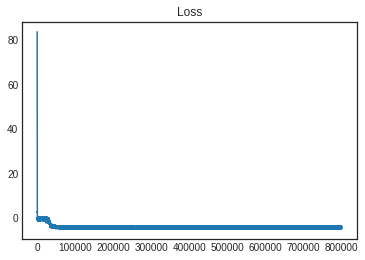

/home/scl489/.env/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


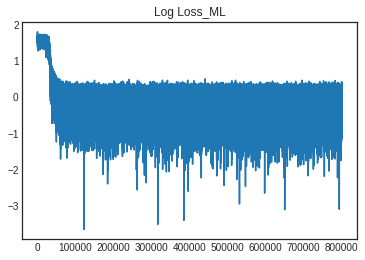

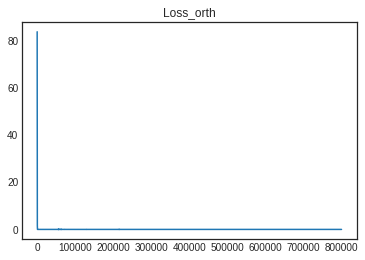

In [16]:
plt.plot(np.arange(epochs), loss_hist)
plt.title("Loss")
plt.show()
plt.plot(np.arange(epochs), np.log(loss_ML_hist - np.amin(loss_ML_hist)))
plt.title("Log Loss_ML")
plt.show()
plt.plot(np.arange(epochs), loss_orth_hist)
plt.title("Loss_orth")
plt.show()

In [17]:
def flow_np(coeff, x, latt_pt):
    coeff = coeff.reshape([-1,1])
    x = x.reshape([-1,1]) 
    latt_pt = latt_pt.reshape([1, -1])
    a = x - latt_pt
    z = np.tanh(a)
    z = np.matmul(z, coeff)
    z = z.reshape(-1,)
    
    det_x = np.matmul(1/(np.cosh(a)**2), coeff)
    
    return z, det_x

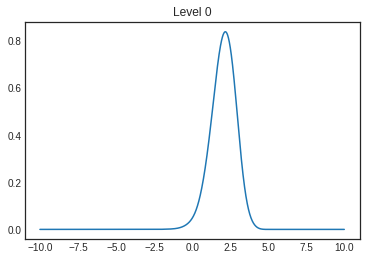

Square integrated over the region: 1.000000000000022


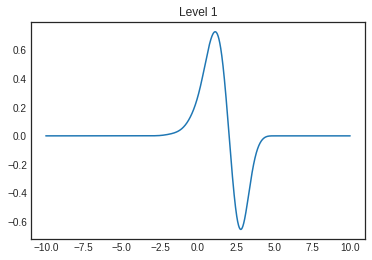

Square integrated over the region: 1.0000000000000222


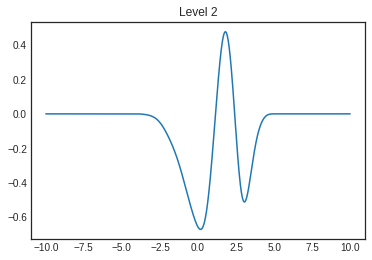

Square integrated over the region: 1.0000000000000233


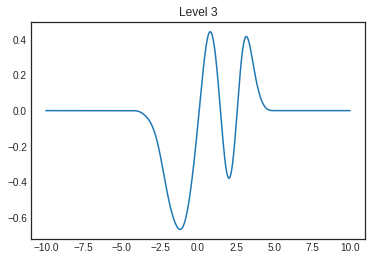

Square integrated over the region: 1.0000000000000226


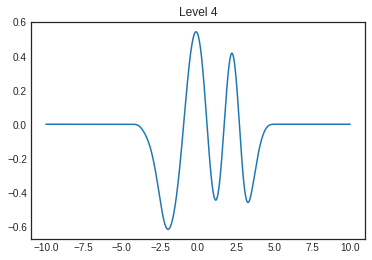

Square integrated over the region: 1.0000000000000226


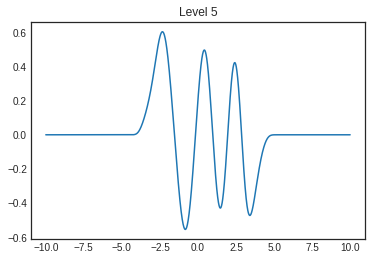

Square integrated over the region: 1.0000000000000215


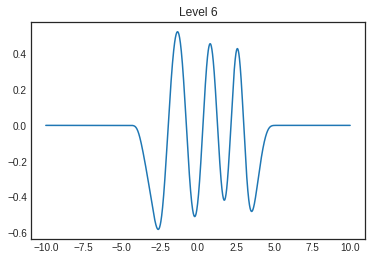

Square integrated over the region: 1.000000000000023


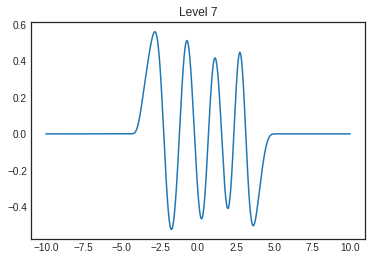

Square integrated over the region: 1.0000000000000244


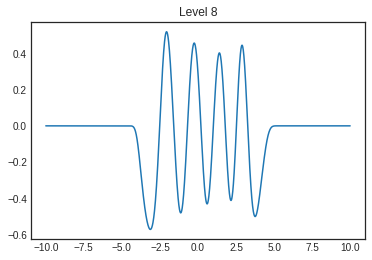

Square integrated over the region: 1.000000000000024


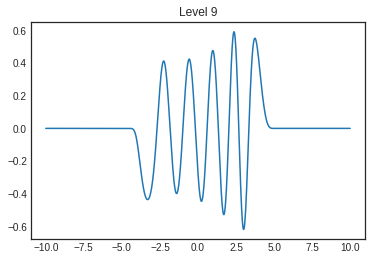

Square integrated over the region: 1.0000000000000202


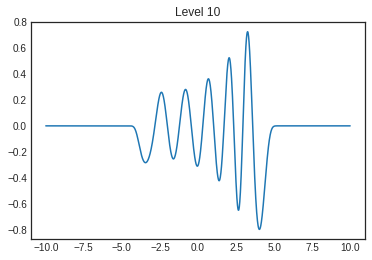

Square integrated over the region: 1.000000000000025


In [18]:
x = np.arange(-10, 10 , 0.01)
n_latt_spacing = 400
latt_pt = np.linspace(-10, 10, num = n_latt_spacing+1)
[z, det_x] = flow_np(fl_coeff, x, latt_pt)

Y = np.sqrt(det_x) * HM(n_Hm, z)

SUP = np.matmul(Y, var_HC_N)

for i in range(n_EL+1):
    plt.plot(x, SUP[:, i])
    plt.title("Level " + str(i))
    plt.show()
    print("Square integrated over the region: " + str(np.sum(SUP[:, i] * SUP[:, i]) * 0.01)) #check wavefunction normalisation

/home/scl489/.env/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


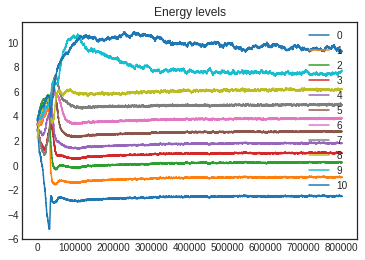

/home/scl489/.env/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


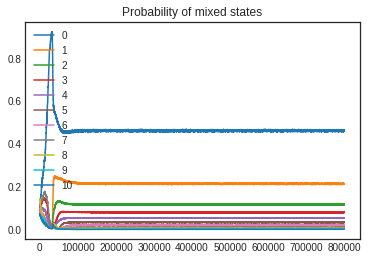

In [19]:
T = 2

for i in range(n_EL+1):
    plt.plot(np.arange(epochs), levels_hist[:,i]*T, label = str(i))

plt.title("Energy levels")    
plt.legend()
plt.show()

for i in range(n_EL+1):
    plt.plot(np.arange(epochs), logits_hist[:,i], label = str(i))

plt.title("Probability of mixed states")    
plt.legend()
plt.show()

In [20]:
print("Energy: ")
print(levels_fin)
print("Probabilities: ")
print(logits_fin)

Energy: 
[-1.2679517  -0.49136666  0.10681308  0.4916364   0.8914576   1.37502284
  1.90402944  2.45808609  3.0898353   3.86726354  4.63523604]
Probabilities: 
[0.46318527 0.21305324 0.11713913 0.07972148 0.05344846 0.03295532
 0.01941694 0.01115725 0.00593187 0.00272621 0.00126483]


In [21]:
print(np.amax(np.abs(np.matmul(var_HC_N.T, var_HC_N) - np.identity(n_EL+1))))

0.001429300599833507
